In [25]:
import numpy as np
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel,BertTokenizer, BertModel
# from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

/Users/debdeeppaul/opt/anaconda3/envs/Shirdi2407/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# Load GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [5]:
# Set pad_token_id to eos_token_id to avoid warnings
model.config.pad_token_id = model.config.eos_token_id

In [6]:
def generate_topic(text, max_length=50):
    prompt = f"The main topic of this document is: {text} The topic is"
    
    # Encode the input prompt
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    
    # Generate the attention mask
    attention_mask = torch.ones(inputs.shape, device=inputs.device)
    
    # Generate text using GPT-2
    with torch.no_grad():
        outputs = model.generate(
            inputs, 
            max_length=max_length, 
            do_sample=True, 
            top_k=50,
            pad_token_id=model.config.eos_token_id,
            attention_mask=attention_mask
        )
    
    # Decode and return the generated text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    
    # Post-process: extract the topic from the generated text
    topic_start = generated_text.find("The topic is") + len("The topic is ")
    topic_end = generated_text.find(".", topic_start)
    
    # Return the inferred topic
    return generated_text[topic_start:topic_end].strip()

In [7]:
# Example: Using GPT-2 for zero-shot topic generation
text_document = "Artificial intelligence is transforming industries with innovative solutions like machine learning and deep learning models. These technologies are being applied in healthcare, finance, and manufacturing. Open AI is doing great!"
topic = generate_topic(text_document)
print(f"Generated Topic: {topic}")

Generated Topic: the rise of A


In [8]:
# Load GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Set pad_token_id to eos_token_id to avoid warnings
model.config.pad_token_id = model.config.eos_token_id

def generate_topic_with_weights(text, max_length=50):
    prompt = f"The main topic of this document is: {text} The topic is"
    
    # Encode the input prompt
    inputs = tokenizer(prompt, return_tensors='pt')
    
    # Generate text using GPT-2 and return logits
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=False, output_attentions=False, return_dict=True)
        logits = outputs.logits
    
    # Decode and return the generated text
    generated_ids = torch.argmax(logits, dim=-1)
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    
    # Post-process: extract the topic from the generated text
    topic_start = generated_text.find("The topic is") + len("The topic is ")
    topic_end = generated_text.find(".", topic_start)
    topic = generated_text[topic_start:topic_end].strip()

    # Extract the weights (probabilities) of the topic tokens
    topic_tokens = tokenizer.encode(topic)
    topic_logits = logits[0, :len(topic_tokens)]
    
    # Calculate softmax to get probabilities
    token_probs = torch.softmax(topic_logits, dim=-1)
    
    # Extract the probabilities for the actual generated topic tokens
    token_weights = [token_probs[i][token_id].item() for i, token_id in enumerate(topic_tokens)]

    # Return the topic and its associated token weights
    return topic, token_weights

# Example: Using GPT-2 for zero-shot topic generation
text_document = "Artificial intelligence is transforming industries with innovative solutions like machine learning and deep learning models. These technologies are being applied in healthcare, finance, and manufacturing."
topic, token_weights = generate_topic_with_weights(text_document)
print(f"Generated Topic: {topic}")
print(f"Topic Token Weights: {token_weights}")


Generated Topic: the article is the
 Intelligence
Topic Token Weights: [8.32683508633636e-05, 0.0004420151235535741, 0.11976153403520584, 0.20330823957920074, 0.00011431064194766805, 1.4388907842999288e-08]


**Guided topic model**

In [9]:
import pandas as pd
df= pd.read_csv('MIR_annotated.csv')
documents= df['text']

In [10]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# Function to generate embeddings for a list of documents
def get_embeddings(documents):
    embeddings = []
    for doc in documents:
        # Tokenize and encode the document
        inputs = tokenizer(doc, return_tensors="pt", max_length=512, truncation=True, padding='max_length')
        with torch.no_grad():
            outputs = model(**inputs)
        # Get the embedding from the CLS token (first token)
        embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze().numpy())
    return embeddings

# Generate embeddings for the documents
document_embeddings = get_embeddings(documents)

In [11]:
# Define the number of clusters (topics)
num_topics = 10 # You can modify this based on your corpus
kmeans = KMeans(n_clusters=num_topics, random_state=42)

# Fit K-Means to the document embeddings
kmeans.fit(document_embeddings)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_  # Get the centroids of the clusters (topics)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Define the number of clusters (topics)
num_topics = 3  # Adjust based on your corpus
top_n= 10
kmeans = KMeans(n_clusters=num_topics, random_state=42)

# Fit K-Means to the document embeddings
kmeans.fit(document_embeddings)
cluster_labels = kmeans.labels_

# Function to extract keywords using TF-IDF for each topic
def extract_top_keywords_per_topic(documents, cluster_labels, num_topics, top_n=5):
    # Group documents by cluster (topic)
    topic_keywords = {}
    for topic in range(num_topics):
        # Get documents belonging to the current topic
        topic_docs = [documents[i] for i in range(len(documents)) if cluster_labels[i] == topic]
        
        # Apply TF-IDF to extract keywords from these documents
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
        tfidf_matrix = tfidf_vectorizer.fit_transform(topic_docs)
        
        # Get the top N keywords based on the TF-IDF scores
        tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
        top_keywords_idx = np.argsort(tfidf_matrix.toarray().mean(axis=0))[-top_n:][::-1]
        top_keywords = tfidf_feature_names[top_keywords_idx]
        
        topic_keywords[topic] = top_keywords
    
    return topic_keywords

# Extract the top 5 keywords for each topic
topic_keywords = extract_top_keywords_per_topic(documents, cluster_labels, num_topics, top_n)

# Print the top keywords for each topic
print("Keywords per Topic:")
for topic, keywords in topic_keywords.items():
    print(f"Topic {topic}: {keywords}")


Keywords per Topic:
Topic 0: ['companies' 'global' '63' 'sanctions' 'confronting' 'imposed' 'invasion'
 'joined' 'leaving' 'march']
Topic 1: ['automotive' 'camless' 'piston' 'engine' 'vehicles' 'electrified'
 'production' 'future' 'stellantis' 'automaker']
Topic 2: ['road' 'said' 'asean' 'safety' 'companies' 'indian' 'market' 'foreign'
 'cars' 'local']


In [13]:
seed_keywords = {
    "Technology": ["artificial intelligence", "machine learning", "deep learning"],
    "Finance": ["blockchain", "decentralized", "finance"],
    "Transportation": ["self-driving", "cars", "automation"]
}

In [14]:
# Function to encode seed words into embeddings
def get_seed_embeddings(seed_keywords):
    seed_embeddings = {}
    for category, keywords in seed_keywords.items():
        embeddings = [model(**tokenizer(keyword, return_tensors='pt'))[0][:, 0, :].squeeze().detach().numpy() for keyword in keywords]
        seed_embeddings[category] = np.array(embeddings)
    return seed_embeddings

# Encode the seed words into embeddings
seed_embeddings = get_seed_embeddings(seed_keywords)



In [19]:
def create_heatmap(data, row_labels, column_labels, title="Heatmap"):
    # Create a DataFrame from the data
    df = pd.DataFrame(data, index=row_labels, columns=column_labels)

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black')

    # Show the plot with title
    plt.title(title)
    plt.show()

In [21]:
# Function to calculate distribution of seed words across topics
def calculate_seed_word_distribution(cluster_centers, seed_embeddings):
    distribution = {}
    for topic_idx, center in enumerate(cluster_centers):
        topic_distribution = {}
        for category, keywords_embeds in seed_embeddings.items():
            # Calculate cosine similarity between the topic centroid and seed word embeddings
            similarity = cosine_similarity([center], keywords_embeds).mean()
            topic_distribution[category] = similarity
        distribution[topic_idx] = topic_distribution
    return distribution

# Calculate the seed word distribution across topics
topic_seedword_distribution = calculate_seed_word_distribution(cluster_centers, seed_embeddings)

# Display the distribution
for topic, distribution in topic_seedword_distribution.items():
    print(f"Topic {topic} Distribution:")
    for category, similarity in distribution.items():
        print(f"{category}: {similarity:.4f}")


Topic 0 Distribution:
Technology: 0.7024
Finance: 0.7308
Transportation: 0.6839
Topic 1 Distribution:
Technology: 0.7276
Finance: 0.7394
Transportation: 0.7108
Topic 2 Distribution:
Technology: 0.7287
Finance: 0.7342
Transportation: 0.7078
Topic 3 Distribution:
Technology: 0.7488
Finance: 0.7208
Transportation: 0.6900
Topic 4 Distribution:
Technology: 0.8199
Finance: 0.7982
Transportation: 0.7673
Topic 5 Distribution:
Technology: 0.7179
Finance: 0.7398
Transportation: 0.7002
Topic 6 Distribution:
Technology: 0.5951
Finance: 0.6436
Transportation: 0.5737
Topic 7 Distribution:
Technology: 0.5256
Finance: 0.5196
Transportation: 0.5092
Topic 8 Distribution:
Technology: 0.7350
Finance: 0.7253
Transportation: 0.7020
Topic 9 Distribution:
Technology: 0.6712
Finance: 0.6873
Transportation: 0.6492


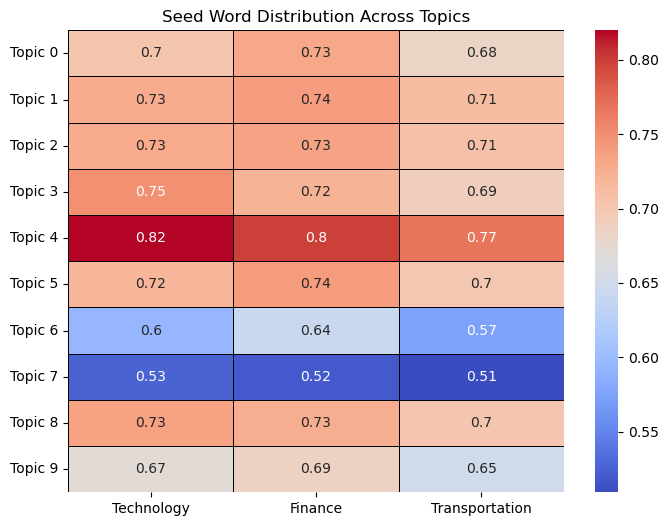

In [26]:
# Step 1: Convert topic_seedword_distribution into a DataFrame
def create_dataframe_from_distribution(topic_seedword_distribution):
    # Extract topics and categories
    topics = list(topic_seedword_distribution.keys())
    categories = list(next(iter(topic_seedword_distribution.values())).keys())
    
    # Prepare the data in a matrix format
    data = {category: [topic_seedword_distribution[topic][category] for topic in topics] for category in categories}
    return pd.DataFrame(data, index=[f'Topic {topic}' for topic in topics])

# Step 2: Create the heatmap from the DataFrame
def visualize_seed_word_distribution_heatmap(topic_seedword_distribution):
    # Convert distribution to DataFrame
    df = create_dataframe_from_distribution(topic_seedword_distribution)
    
    # Use the previous heatmap function to create the heatmap
    create_heatmap(df, df.index, df.columns, title="Seed Word Distribution Across Topics")

# Example usage: Visualize the heatmap
visualize_seed_word_distribution_heatmap(topic_seedword_distribution)
